In [1]:
import sys, os
PROJECT_ROOT = r"D:\bhermosi\chestxsim-project"  
SRC = os.path.join(PROJECT_ROOT, "src")
if SRC not in sys.path:
    sys.path.insert(0, SRC)


In [2]:
import os, re
import cupy as cp
import imageio.v3 as iio
import numpy as np
from pathlib import Path

def save_tif(array, folder, filename):
    os.makedirs(folder, exist_ok=True)
    if isinstance(array, cp.ndarray):
        array = cp.asnumpy(array)
    path = Path(folder) / Path(filename).name
    iio.imwrite(path, array.astype(np.float32))

In [ ]:
from chestxsim.core import CBCTGeometry
from chestxsim.wrappers.astra import Astra_CBCT, GeometryMode
from chestxsim.utility import plot 

base = r"D:\bhermosi\chestxsim-project\examples\volumes"
folder_path = base + "\density"
patient_id = 994
px_size = (0.576, 0.576)
img_shape = (512,512)

# ================ LOAD 2D SLICES PER PATIENT  ====================
files = [f for f in os.listdir(folder_path) if f.endswith(".tif")]
patient_files = [f for f in files if f"CT_train_{patient_id}_" in f]

def get_slice_number(filename):
    match = re.search(r"slice_(\d+)", filename)
    return int(match.group(1)) if match else -1


patient_files.sort(key=get_slice_number)
images = [iio.imread(os.path.join(folder_path, f)) for f in patient_files]
# volume = np.stack(images, axis=2)[:, :, ::-1] #solo para el 3d 
volume = np.stack(images, axis=2)

print(f"Loaded {len(images)} slices for patient {patient_id}.")
print(f"Volume shape: {volume.shape}")

# =============== DEFINE SYSTEM GEOMETRY =================
system_geo = CBCTGeometry(
    detector_size = [4288, 4288],
    pixel_size= [0.1, 0.1],
    binning_proj = 4,
    SDD = 1100,
    DOD = 307.452,
    nprojs = 360,
    step_angle = 1,
    init_angle= -90

)

# ============== SELECT CBCT MODE 2D =============
multivet = Astra_CBCT(system_geo)
multivet.set_geometry_mode(GeometryMode.CBCT2D)
multivet.set_fbp_filter('ram-lak')
multivet.set_beam_geometry('parallel') # or 'fanflat'

# ============== GENERATE 2D PROJ AND RECO ===============
vol = cp.asarray(volume) # move to gpu 
num_slices = vol.shape[2]
for i in range(num_slices):
    sl = vol[:, :, i]  
    sino = multivet.project(sl, px_size)
    # save_tif(sino, folder=base + "\sino_2D_astra_parallel", filename=patient_files[i])

    reco = multivet.fbp(sino, img_shape, px_size)
    # save_tif(reco, folder=base + "\FBP_2D_astra_parallel", filename=patient_files[i])

    print(f"{patient_files[i]} done")

    # del sl, sino, reco
    # cp.get_default_memory_pool().free_all_blocks()
    # cp.cuda.Stream.null.synchronize()
    break


GPU detected: Using CuPy with 1 device(s), current device: 0
Loaded 503 slices for patient 994.
Volume shape: (512, 512, 503)
CT_train_994_d_2_voxel_0.576x0.576_dims_512x512_slice_0.tif done


Density vs Sinogram  vs Reconstructed slice  


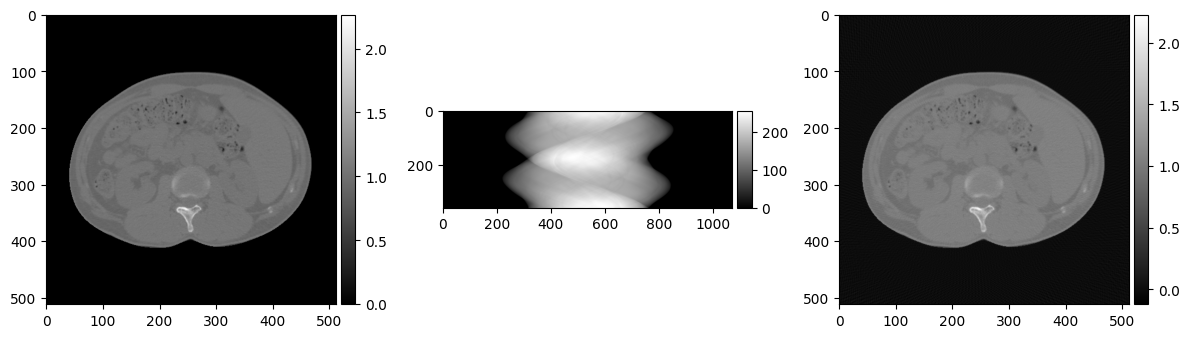

In [6]:
print("Density vs Sinogram  vs Reconstructed slice  ")
plot(sl.get(), sino.get(), reco.get())

In [7]:
# ====EJEMPLO DE USO PARA 3D ======
vx_size = (0.576, 0.576, 0.576)
reco_size = (512,512,len(images))
volume = np.stack(images, axis=2)[:, :, ::-1] # las imagenes estan ordenadas al reves - 

# ==== SET 3D CBCT MODE ====
multivet = Astra_CBCT(system_geo)
multivet.set_geometry_mode(GeometryMode.CBCT3D)
multivet.set_fbp_filter('ram-lak')

# ==== GENERATE 3D PROJs AND RECO ==============
projs = multivet.project(volume, vx_size)
reco = multivet.fbp(projs,reco_size, vx_size)

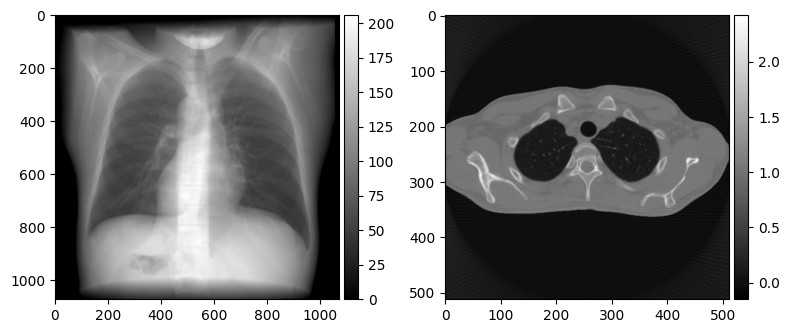

In [ ]:
plot(projs[:,:,100].get().T, reco[:,:,100].get())